##### “Should This Loan be Approved or Denied?”

    This assignment is ideal for data analysis courses for several reasons.
        1. The case study incorporates all of the 2016 GAISE recommendations.
        2. The topic itself captures students’ interest, for it is an application of actual data related to 
            real-life financial decisions.
        3. Students are exposed to managing a large dataset and understanding how historical 
            data can be used to make informed decisions.
        4. Critical thinking is promoted; analysis, synthesis, and decision making skills are used.
        5. Students are introduced to logistic regression and other more advanced methods for classification.
        6. The importance of identifying reasonable explanatory variables (e.g., risk indicators for loan default) 
            to incorporate into statistical models provides lively and engaging discussions

#### Importing Libraries for our use :

In [472]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns, plotly.express as px
import regex as re
import math

import missingno as msno
import warnings
warnings.filterwarnings('ignore')

    Reading the Data Frame so that we can Check whats Going right Here. 

In [473]:
cred_df = pd.read_csv("SBAnational.csv")
cred_df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [474]:
# print(f"There are {cred_df.shape[0]} Rows and having {cred_df.shape[1]} Columns!")
# print("And some columns ")
print(f"The Shape of the train data in form of\n( Rows - {cred_df.shape[0]}, Columns - {cred_df.shape[1]})")

The Shape of the train data in form of
( Rows - 899164, Columns - 27)


In [475]:
cred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

<Axes: >

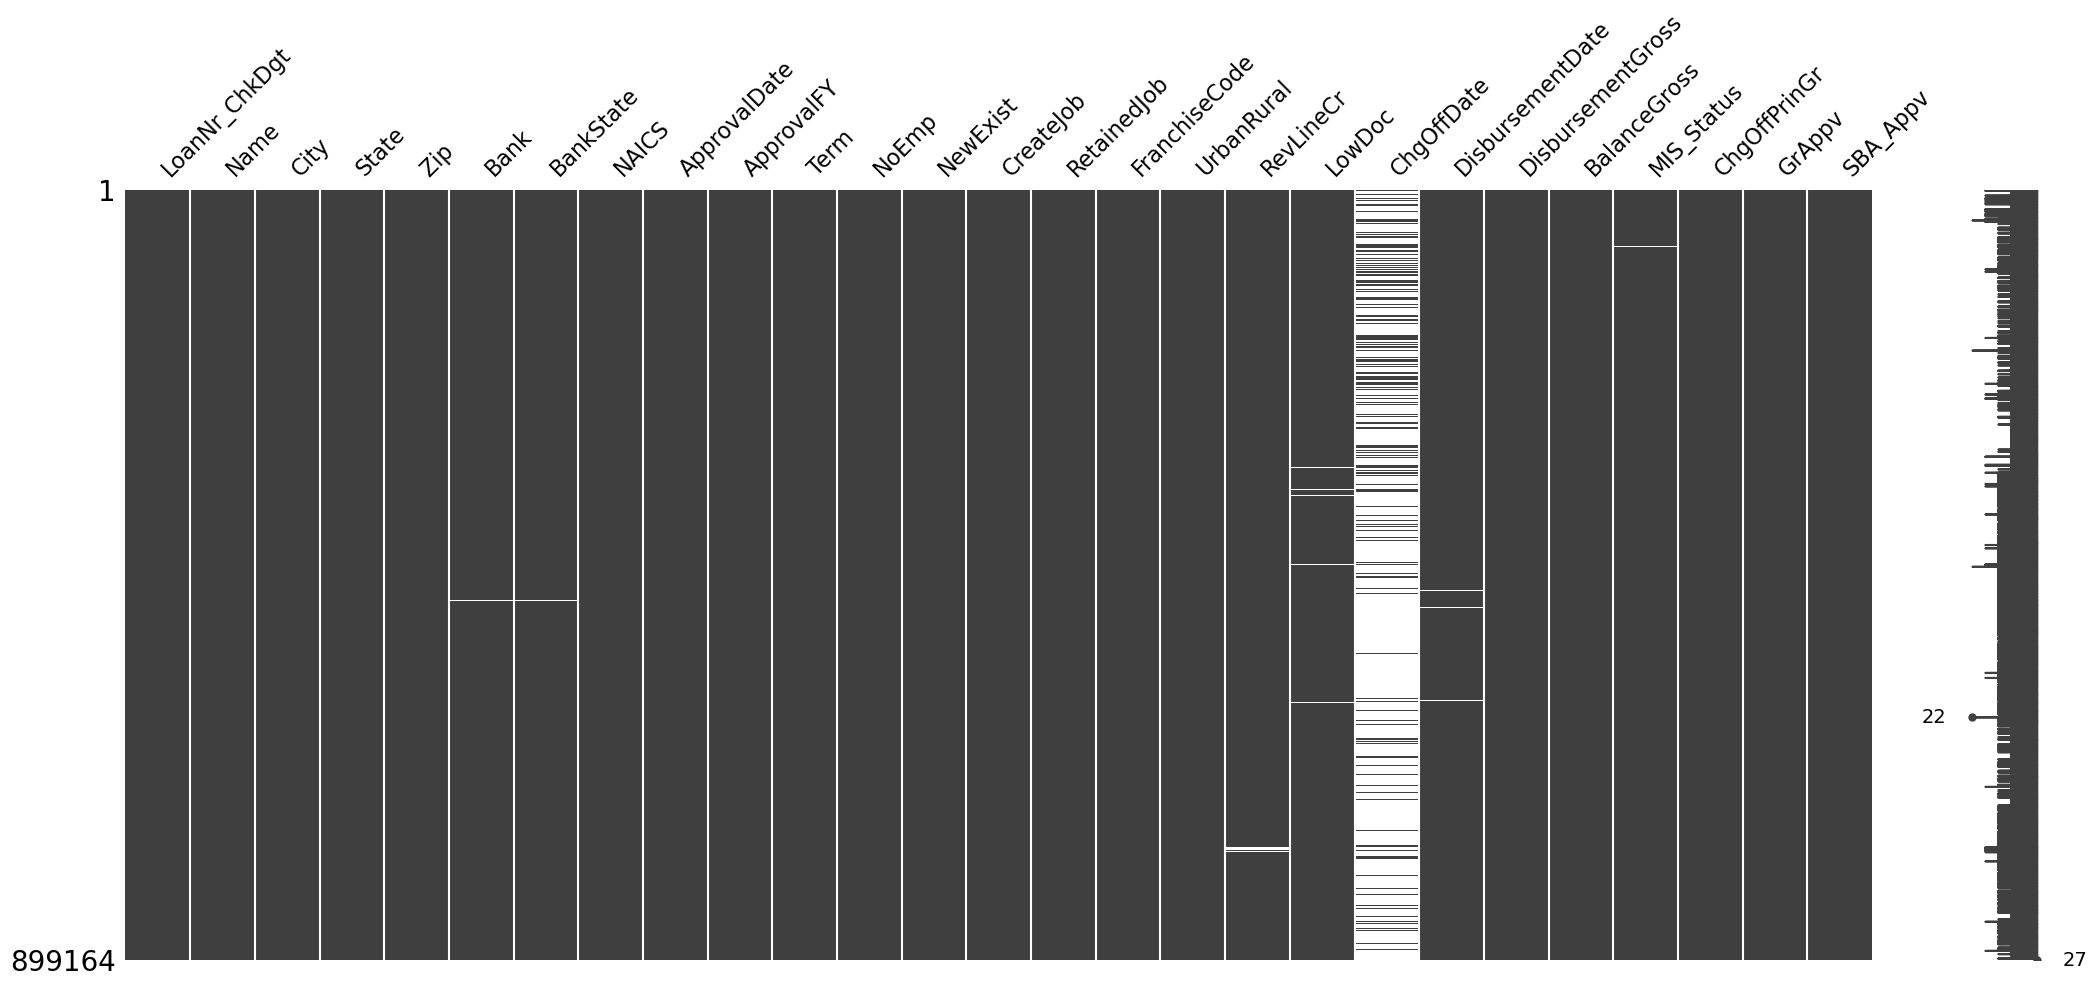

In [476]:
msno.matrix(cred_df)

In [477]:
def null_counter(data) :
    count = data.isnull().sum()
    percen = count / len(data) * 100

    count.sort_values(ascending = False)
    percen.sort_values(ascending = False)

    df_null = pd.DataFrame({
        'column name' : data.columns,
        'total count' : count,
        'percentage' : percen
    })

    df_null.reset_index(drop = True, inplace = True)
    df_null_sorted = df_null.sort_values(by='percentage', ascending=False)
    df_filtered = df_null_sorted[df_null_sorted['percentage'] > 0]
    return df_filtered

In [478]:
null_counter(cred_df)

,column name,total count,percentage
19,ChgOffDate,736465,81.905526
17,RevLineCr,4528,0.503579
18,LowDoc,2582,0.287156
20,DisbursementDate,2368,0.263356
23,MIS_Status,1997,0.222095
6,BankState,1566,0.174162
5,Bank,1559,0.173383
12,NewExist,136,0.015125
2,City,30,0.003336
3,State,14,0.001557


In [479]:
cred_df['ChgOffDate']

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
899159         NaN
899160         NaN
899161         NaN
899162    8-Mar-00
899163         NaN
Name: ChgOffDate, Length: 899164, dtype: object

    Given ChgOffDate as per domain knowledge :
        The date when a loan is declared to be in default
        and looks like it is anonymns. So am dropping it.

In [480]:
cred_df.drop('ChgOffDate', axis = 1, inplace = True)

In [481]:
empt = null_counter(cred_df)['column name'].tolist()
empt

['RevLineCr',
 'LowDoc',
 'DisbursementDate',
 'MIS_Status',
 'BankState',
 'Bank',
 'NewExist',
 'City',
 'State',
 'Name']

In [482]:
cred_df[empt].dtypes

RevLineCr            object
LowDoc               object
DisbursementDate     object
MIS_Status           object
BankState            object
Bank                 object
NewExist            float64
City                 object
State                object
Name                 object
dtype: object

    Only the NewExist seems that in float values so imputing all Object Null columns with mode and NewExist with median.

In [483]:
for col in cred_df.columns:
    if col in empt and cred_df[col].dtype == object:
        mode_value = cred_df[col].mode()[0]
        cred_df[col].fillna(mode_value, inplace=True)

In [484]:
cred_df['NewExist'].fillna(cred_df['NewExist'].median(), inplace=True)

In [485]:
null_counter(cred_df)

,column name,total count,percentage


    Treated Null values and fill all the values which is determined for outer :-
***
    Lets take a view of the given Dataset to know about the actual terms :
        1. There are 27 Features/Columns from which we have 
            10 Numerical Columns and 17 Categorical Columns.
        2. Here we got some Null values where ChgOffDate was some 81% and other were below 1%
            so so imputing all Object Null columns with mode and NewExist with median.
        3. At last these columns are mostly used to specify the actual default the Credits.

In [486]:
cred_df.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'DisbursementDate', 'DisbursementGross', 'BalanceGross',
       'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')

In [487]:
cred_df[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']] = \
cred_df[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', '')).astype(float)

In [488]:
print(cred_df['LoanNr_ChkDgt'])

0         1000014003
1         1000024006
2         1000034009
3         1000044001
4         1000054004
             ...    
899159    9995573004
899160    9995603000
899161    9995613003
899162    9995973006
899163    9996003010
Name: LoanNr_ChkDgt, Length: 899164, dtype: int64


    The LoanNr_ChkDgt is working as Row No so not so much important! 

In [489]:
cred_df.drop('LoanNr_ChkDgt', inplace = True, axis = 1)

In [490]:
def bar_plot(col) :
    top_names = cred_df[col].value_counts().head(20).reset_index()
    top_names.columns = [col, 'Count']

    plt.figure(figsize = [12, 6])
    sns.barplot(data = top_names, x = col, y = 'Count', palette = 'pastel')
    plt.title(f'Top 20 Borrower {col}', fontsize = 16)
    plt.xlabel(f'Borrower {col}', fontsize = 14)
    plt.ylabel('Count', fontsize = 14)
    plt.xticks(rotation = 45, ha = 'right') 
    plt.tight_layout()

In [491]:
cred_df['Name'].value_counts()

Name
SUBWAY                            1283
QUIZNO'S SUBS                      433
COLD STONE CREAMERY                366
QUIZNO'S                           345
DOMINO'S PIZZA                     329
                                  ... 
Mohammad N. Hassan (epc) for C       1
N.J. Yellow Tale Flower              1
CEF INC.                             1
SCANNELL AND ASSOCIATES LP           1
PACIFIC TRADEWINDS FAN & LIGHT       1
Name: count, Length: 779583, dtype: int64

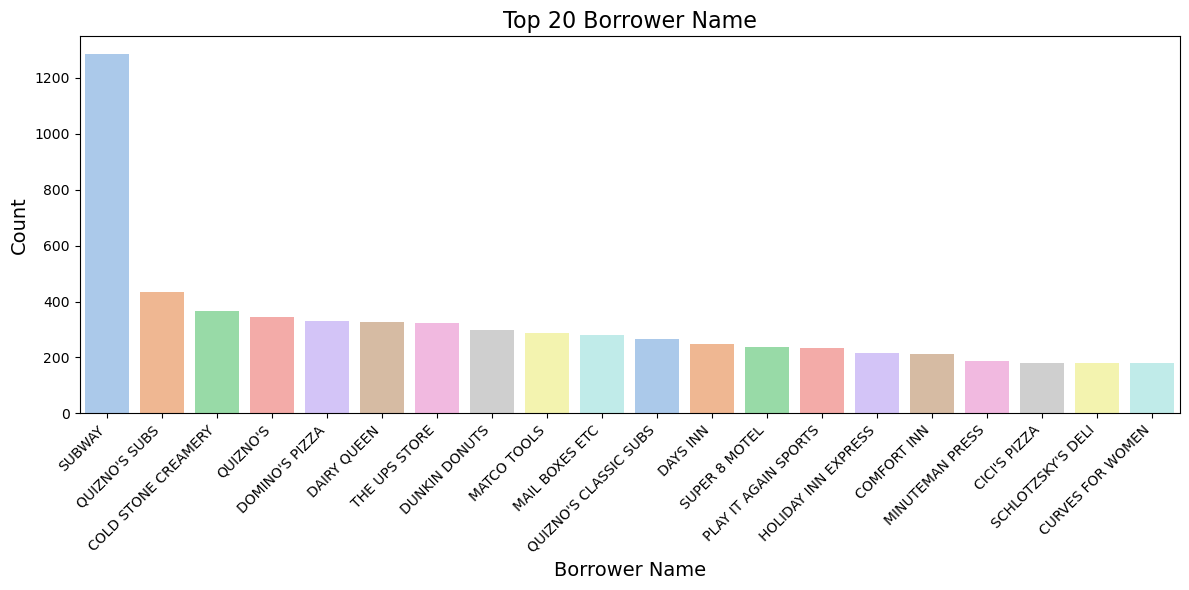

In [492]:
bar_plot('Name')

    In the Small Business name we have some top business which are most countable to appear for 
        loan is SUBWAY then QUIZNO'S SUBS and more .. 
    As the Name of the Small Buisness aren't important but can be useful if needed so not removing them.

In [493]:
cred_df['City'].value_counts()

City
LOS ANGELES                       11588
HOUSTON                           10247
NEW YORK                           7846
CHICAGO                            6036
MIAMI                              5594
                                  ...  
EL DORADO SPRINGS (ELDORADO SP        1
HUNTINDON                             1
LEBAHON                               1
WILLOW RIVER                          1
SO. OZONE PARK                        1
Name: count, Length: 32581, dtype: int64

In [494]:
cred_df['City'].unique()

array(['EVANSVILLE', 'NEW PARIS', 'BLOOMINGTON', ..., 'MURFRECSBORO',
       'E WENALCHEE', 'SO. OZONE PARK'], dtype=object)

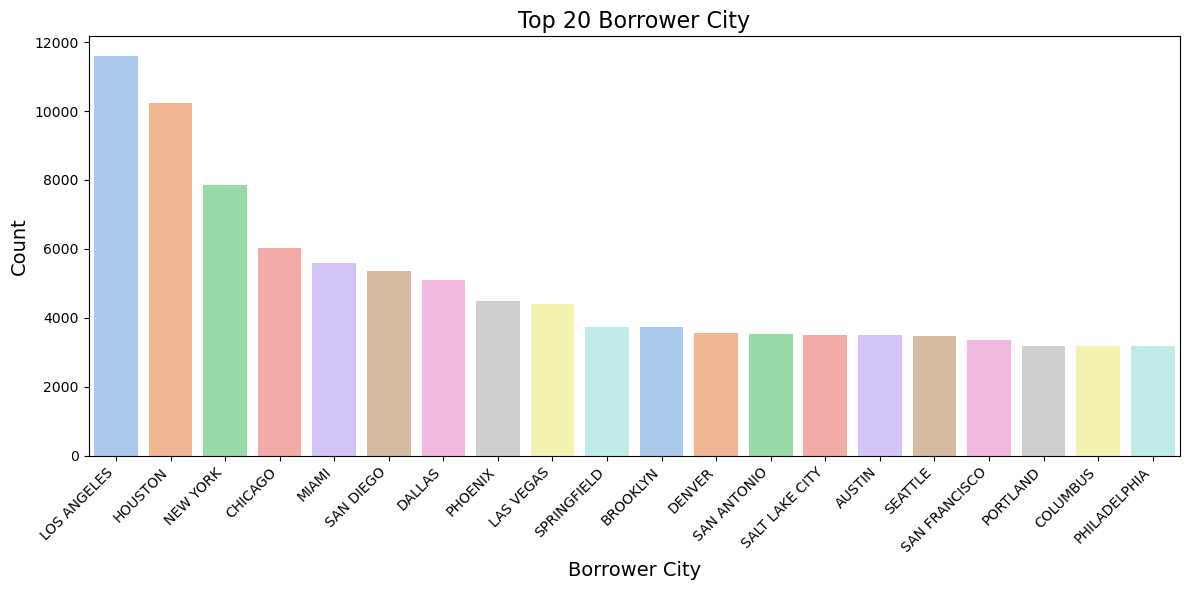

In [495]:
bar_plot('City')

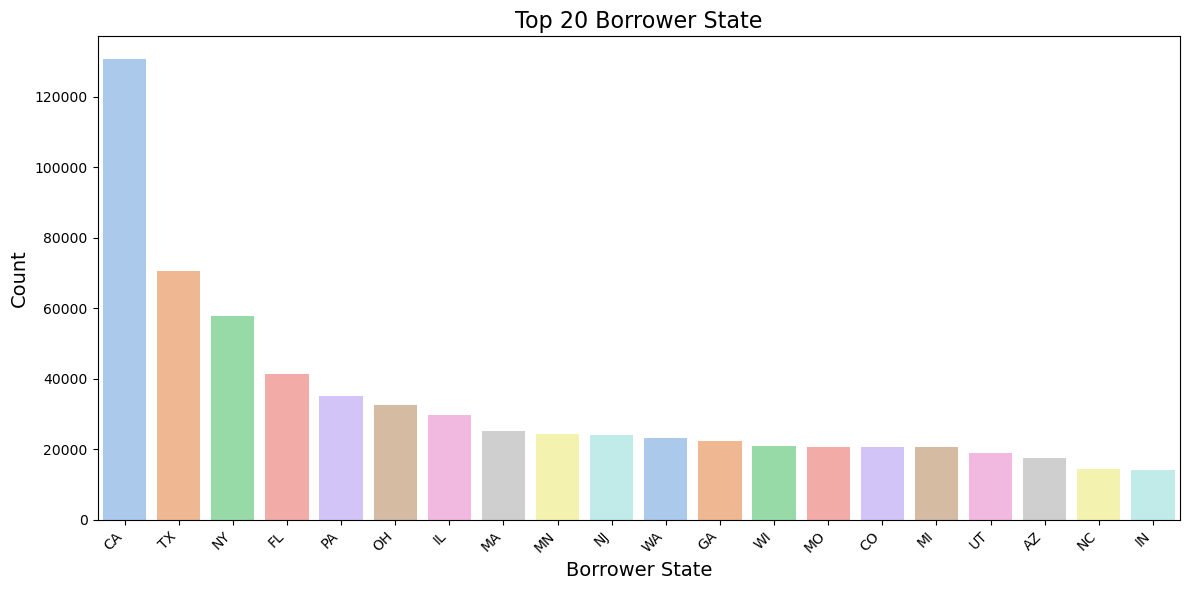

In [496]:
bar_plot('State')

    The City and State columns describes that most of the Small Business are From the 
        Los Angeles then moving to Houston, New York, Chicago etc.. 
        
    City and State can determine the Fraud containg ares ..
    
    Key Point : This State and City indicates that the dataset is from the United States.

In [497]:
cred_df['Zip'] = cred_df['Zip'].astype(int)

In [498]:
cred_df['Zip'].value_counts()

Zip
10001    933
90015    926
93401    806
90010    733
33166    671
        ... 
33789      1
32524      1
61870      1
97711      1
26134      1
Name: count, Length: 33611, dtype: int64

    the Zip column typically refers to ZIP codes, which are numerical codes used by the 
    United States Postal Service (USPS) to identify specific geographic areas

In [499]:
cred_df['Bank'].value_counts()

Bank
BANK OF AMERICA NATL ASSOC        88412
WELLS FARGO BANK NATL ASSOC       63503
JPMORGAN CHASE BANK NATL ASSOC    48167
U.S. BANK NATIONAL ASSOCIATION    35143
CITIZENS BANK NATL ASSOC          35054
                                  ...  
FIRST LANDMARK BANK                   1
MASON CITY NATIONAL BANK              1
FARMERS ST. BK OF CAMP POINT          1
CAPITAL BANK CORPORATION              1
DEPCO                                 1
Name: count, Length: 5802, dtype: int64

In [500]:
cred_df['NAICS'].value_counts()

NAICS
0         201948
722110     27989
722211     19448
811111     14585
621210     14048
           ...  
927110         1
327410         1
314992         1
922110         1
325192         1
Name: count, Length: 1312, dtype: int64

    Bank:
        This column usually contains the name of the financial institution or bank that issued the loan. 
        It helps identify which banks are participating in the lending process.
    
    BankState:
        This indicates the state in which the bank is located. It can help analyze regional lending 
        patterns or the concentration of banks in different states.

In [501]:
cred_df['ApprovalDate'].value_counts()

ApprovalDate
7-Jul-93     1131
30-Jan-04    1032
8-Jul-93      780
4-Oct-04      658
30-Sep-03     608
             ... 
29-May-75       1
21-Feb-75       1
25-Apr-67       1
12-Apr-72       1
19-Sep-74       1
Name: count, Length: 9859, dtype: int64

In [502]:
cred_df['ApprovalFY'].value_counts()

ApprovalFY
2006    76040
2007    71876
2003    58193
2005    52912
1995    45758
        ...  
1968        1
1962        1
1967        1
1965        1
1966        1
Name: count, Length: 70, dtype: int64

In [503]:
cred_df['ApprovalFY'].unique()

array([1997, 1980, 2006, 1998, 1999, 2000, 2001, 1972, 2003, 2004, 1978,
       1979, 1981, 2005, 1962, 1982, 1965, 1966, 1983, 1973, 1984, 2007,
       1985, 1986, 1987, 2008, 1988, 2009, 1989, 1991, 1990, 1974, 2010,
       1967, 2011, 1992, 1993, 2002, 2012, 2013, 1994, 2014, 1975, 1977,
       1976, 1968, '2004', '1994', '1979', '1976', '1967', '1975', '1974',
       '1977', '1981', '1982', '1983', '1984', '1978', '1980', '1968',
       '1976A', '1969', '1995', '1970', '2005', '1996', '1971', 1996,
       1971], dtype=object)

    There is some A in values so gtreating them for better use!

In [504]:
def clean_str(x):
    if isinstance(x, str):
        return x.replace('A', '')
    return x

cred_df.ApprovalFY = cred_df.ApprovalFY.apply(clean_str).astype('int64')

     ApprovalFY:
        This represents the fiscal year in which the loan was approved. It can be useful for financial 
        reporting and trend analysis, particularly in assessing annual loan volumes.

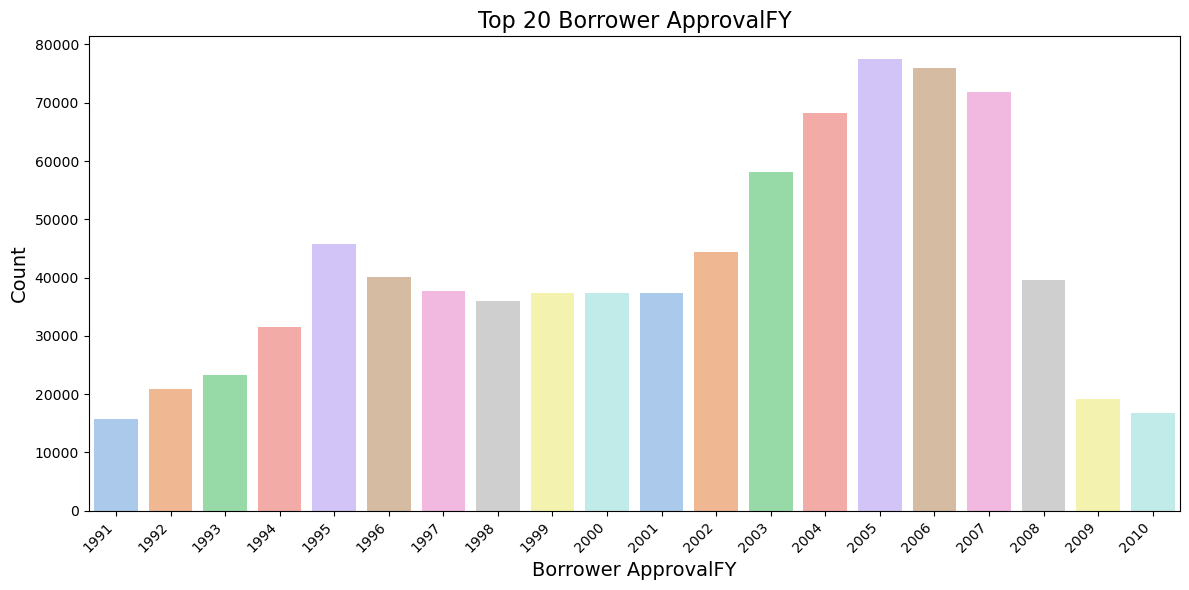

In [505]:
bar_plot('ApprovalFY')

In [506]:
cred_df.groupby('Name')['NoEmp'].sum()

Name
"216" PIANO BAR                   6
"360" SALON & DAY SPA             6
"821"                            50
"A CLASS ACT" BEAUTY SALON        7
"A LA MODE" ICE CREAM PARLOUR     5
                                 ..
world class construction mgmt     1
www.campfiregrill.com, LLC        3
y city recycling llc             65
yeadon brewer's outlet, inc       2
z on 2nd, LLC                    10
Name: NoEmp, Length: 779583, dtype: int64

    NoEmp:
        This refers to the number of employees in the borrowing business. This information can help assess the 
            size of the business and is often used to determine eligibility for certain types of loans.

In [507]:
bins = [0, 50, 250, 1000, 4847]
labels = ['Small', 'Medium', 'Large', 'Very Large']

cred_df['NoEmp'] = pd.cut(cred_df['NoEmp'], bins=bins, labels=labels, include_lowest=True)
cred_df['NoEmp'].value_counts()

NoEmp
Small         871813
Medium         26122
Large            977
Very Large       183
Name: count, dtype: int64

In [508]:
cred_df['NewExist'].value_counts()

NewExist
1.0    645005
2.0    253125
0.0      1034
Name: count, dtype: int64

In [509]:
cred_df['NewExist'].astype(int)
cred_df['NewExist'].value_counts()

NewExist
1.0    645005
2.0    253125
0.0      1034
Name: count, dtype: int64

In [510]:
filtered_names = cred_df['Name'][(cred_df['NewExist'] == 0) & (cred_df['NewExist'] == 1)]
filtered_names

Series([], Name: Name, dtype: object)

In [511]:
cred_df[cred_df['Name'] == 'WHITLOCK DDS, TODD M.']

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,...,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
2,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,180,...,0,N,N,31-Dec-97,287000.0,0.0,P I F,0.0,287000.0,215250.0


In [512]:
cred_df['NewExist'] = np.where(cred_df['NewExist'] == 1, 0,
                                np.where(cred_df['NewExist'] == 2, 1, np.nan))

In [513]:
cred_df['NewExist'].value_counts()

NewExist
0.0    645005
1.0    253125
Name: count, dtype: int64

    About NewExist indicates the status of a business concerning its establishment as either new or existing. 

In [514]:
cred_df['CreateJob']

0         0
1         0
2         0
3         0
4         7
         ..
899159    0
899160    0
899161    0
899162    0
899163    0
Name: CreateJob, Length: 899164, dtype: int64

In [515]:
cred_df['RetainedJob']

0         0
1         0
2         0
3         0
4         7
         ..
899159    0
899160    0
899161    0
899162    0
899163    0
Name: RetainedJob, Length: 899164, dtype: int64

In [516]:
cred_df[['CreateJob', 'RetainedJob']].corr()

,CreateJob,RetainedJob
CreateJob,1.000000,0.993953
RetainedJob,0.993953,1.000000


In [517]:
cred_df["TotalJobs"] = cred_df["CreateJob"] + cred_df["RetainedJob"]

    It seems that there is a correlation between CreateJob and RetainedJob so dropping one of them here.

In [518]:
cred_df['FranchiseCode']

0         1
1         1
2         1
3         1
4         1
         ..
899159    1
899160    1
899161    1
899162    1
899163    1
Name: FranchiseCode, Length: 899164, dtype: int64

     Franchise Code is a classification used in various datasets, particularly in the context of loans or business 
     applications, to indicate whether a business is part of a franchise and, if so, to identify the type of franchise.

In [519]:
cred_df.loc[(cred_df['FranchiseCode'] <= 1), 'FranchiseCode'] = 0
cred_df.loc[(cred_df['FranchiseCode'] > 1), 'FranchiseCode'] = 1

In [520]:
cred_df['FranchiseCode'].value_counts()

FranchiseCode
0    847389
1     51775
Name: count, dtype: int64

In [521]:
cred_df['UrbanRural'].value_counts()

UrbanRural
1    470654
0    323167
2    105343
Name: count, dtype: int64

In [522]:
mapped = {
    0: 'Undefined',
    1: 'Urban',
    2: 'Rural'
}

cred_df['UrbanRural'] = cred_df['UrbanRural'].map(mapped)

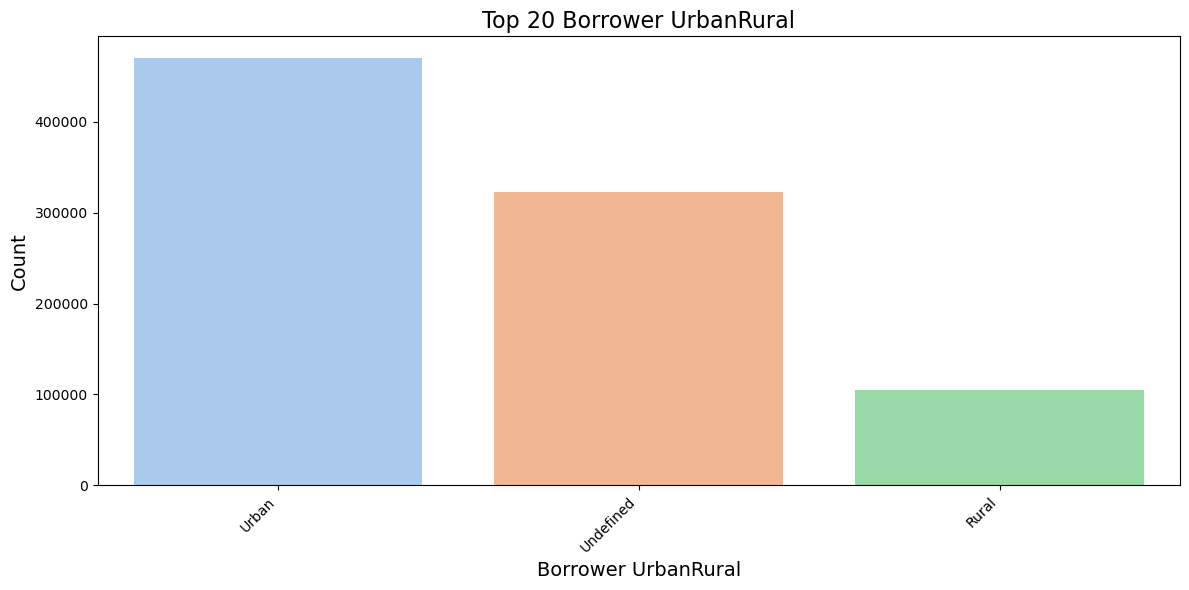

In [523]:
bar_plot('UrbanRural')

In [524]:
cred_df['RevLineCr'].value_counts()

RevLineCr
N    424816
0    257602
Y    201397
T     15284
1        23
R        14
`        11
2         6
C         2
3         1
,         1
7         1
A         1
5         1
.         1
4         1
-         1
Q         1
Name: count, dtype: int64

In [525]:
cred_df['RevLineCr'] = np.where(cred_df['RevLineCr'] == 'Y', 1,
                                np.where(cred_df['RevLineCr'] == 'N', 0, np.nan))

In [526]:
cred_df['RevLineCr'].value_counts()

RevLineCr
0.0    424816
1.0    201397
Name: count, dtype: int64

    Watching why Revolving line of credit is 0

In [527]:
cred_df['LowDoc'] = np.where(cred_df['LowDoc'] == 'Y', 1,
                                np.where(cred_df['LowDoc'] == 'N', 0, np.nan))

In [528]:
cred_df['LowDoc'].value_counts()

LowDoc
0.0    785404
1.0    110335
Name: count, dtype: int64

In [529]:
cred_df.RevLineCr.unique()

array([ 0., nan,  1.])

In [530]:
cred_df.LowDoc.unique()

array([ 1.,  0., nan])

In [531]:
cred_df['DisbursementDate']

0         28-Feb-99
1         31-May-97
2         31-Dec-97
3         30-Jun-97
4         14-May-97
            ...    
899159    30-Sep-97
899160    31-Oct-97
899161    30-Sep-97
899162    31-Mar-97
899163    31-May-97
Name: DisbursementDate, Length: 899164, dtype: object

In [532]:
cred_df['ApprovalDate'] = pd.to_datetime(cred_df['ApprovalDate'], format='%d-%b-%y')
cred_df['DisbursementDate'] = pd.to_datetime(cred_df['DisbursementDate'], format='%d-%b-%y')
cred_df['DaysToDisbursement'] = cred_df['DisbursementDate'] - cred_df['ApprovalDate']

In [533]:
cred_df['DaysToDisbursement'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 899164 entries, 0 to 899163
Series name: DaysToDisbursement
Non-Null Count   Dtype          
--------------   -----          
899164 non-null  timedelta64[ns]
dtypes: timedelta64[ns](1)
memory usage: 6.9 MB


In [534]:
cred_df['DaysToDisbursement'] = cred_df['DaysToDisbursement'].dt.days

In [535]:
cred_df['DisbursementFY'] = cred_df['DisbursementDate'].map(lambda x: x.year)

In [536]:
cred_df[cred_df["DaysToDisbursement"] < 0]

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,...,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,TotalJobs,DaysToDisbursement,DisbursementFY
452,"Symmetry Systems, Inc.",Latham,NY,12110,KEYBANK NATIONAL ASSOCIATION,OH,0,1998-11-27,1999,60,...,1995-07-31,50000.0,0.0,P I F,0.0,50000.0,25000.0,0,-1215,1995
481,"AQUA BELLA ENTERPRISES, INC.",CHICAGO,IL,60634,NORTH COMMUNITY BANK,IL,0,1980-06-25,1980,87,...,1980-05-12,350000.0,0.0,CHGOFF,311636.0,350000.0,315000.0,0,-44,1980
1183,Virtuo Group Corporation,The Woodlands,TX,77382,WELLS FARGO BANK NATL ASSOC,TX,541990,2003-10-09,2004,13,...,1995-07-31,190000.0,0.0,P I F,0.0,190000.0,95000.0,0,-2992,1995
1382,Fairfax Family Physical Therap,FAIRFAX,VT,5454,"TD BANK, NATIONAL ASSOCIATION",DE,621498,2003-12-12,2004,84,...,1995-07-31,10000.0,0.0,P I F,0.0,10000.0,5000.0,0,-3056,1995
1525,"Haberle Steel, Inc.",CONSHOHOCKEN,PA,19428,UNIVEST BANK AND TRUST CO.,PA,331221,2004-03-16,2004,60,...,1995-07-31,75000.0,0.0,P I F,0.0,75000.0,37500.0,0,-3151,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897268,ROJAS RENTALS,LOS ANGELES,CA,90023,WELLS FARGO BANK NATL ASSOC,SD,0,1997-02-10,1997,60,...,1995-07-31,10000.0,0.0,P I F,0.0,10000.0,5000.0,0,-560,1995
897488,EFM ASSOCIATES,LOS ANGELES,CA,90068,WELLS FARGO BANK NATL ASSOC,SD,531110,1997-02-12,1997,60,...,1995-07-31,35000.0,0.0,P I F,0.0,35000.0,17500.0,0,-562,1995
897494,DOUGLAS WATANABE DDS INC,CREVE COEUR,MO,63141,U.S. BANK NATIONAL ASSOCIATION,MO,621210,1997-02-12,1997,120,...,1995-07-31,230000.0,0.0,P I F,0.0,230000.0,172500.0,0,-562,1995
898373,"CROWN JEWELERS, LTD.",STAUNTON,VA,24401,UNION FIRST MARKET BANK,VA,448310,1997-02-21,1997,299,...,1987-04-01,50000.0,0.0,P I F,0.0,50000.0,37500.0,0,-3614,1987


    Seems that the loan was disbursed before it was approved so as am dropping it.

In [537]:
cred_df.drop(cred_df[cred_df["DaysToDisbursement"] < 0].index, inplace = True)

In [538]:
cred_df["Term"] = cred_df["Term"] / 12

In [539]:
bins = [0, 5, 15, 27]
labels = ['Short Term', 'Medium Term', 'Large Term']

cred_df['Term'] = pd.cut(cred_df['Term'], bins=bins, labels=labels, include_lowest=True)

In [540]:
cred_df['Term'].value_counts()

Term
Medium Term    465282
Short Term     265067
Large Term     165712
Name: count, dtype: int64

In [541]:
cred_df['BalanceGross'].value_counts(normalize = True).head(4)

BalanceGross
0.0         0.999984
12750.0     0.000001
827875.0    0.000001
25000.0     0.000001
Name: proportion, dtype: float64

In [542]:
cred_df['ChgOffPrinGr'].value_counts()

ChgOffPrinGr
0.0         734560
50000.0       2105
10000.0       1864
25000.0       1367
35000.0       1345
             ...  
10734.0          1
21267.0          1
706512.0         1
96424.0          1
124847.0         1
Name: count, Length: 83105, dtype: int64

In [543]:
cred_df['GrAppv']

0          60000.0
1          40000.0
2         287000.0
3          35000.0
4         229000.0
            ...   
899159     70000.0
899160     85000.0
899161    300000.0
899162     75000.0
899163     30000.0
Name: GrAppv, Length: 896326, dtype: float64

In [544]:
cred_df['SBA_Appv']

0          48000.0
1          32000.0
2         215250.0
3          28000.0
4         229000.0
            ...   
899159     56000.0
899160     42500.0
899161    225000.0
899162     60000.0
899163     24000.0
Name: SBA_Appv, Length: 896326, dtype: float64

In [545]:
cred_df.dtypes

Name                          object
City                          object
State                         object
Zip                            int32
Bank                          object
BankState                     object
NAICS                          int64
ApprovalDate          datetime64[ns]
ApprovalFY                     int64
Term                        category
NoEmp                       category
NewExist                     float64
CreateJob                      int64
RetainedJob                    int64
FranchiseCode                  int64
UrbanRural                    object
RevLineCr                    float64
LowDoc                       float64
DisbursementDate      datetime64[ns]
DisbursementGross            float64
BalanceGross                 float64
MIS_Status                    object
ChgOffPrinGr                 float64
GrAppv                       float64
SBA_Appv                     float64
TotalJobs                      int64
DaysToDisbursement             int64
D

    Dropping some columns as per there no work :
        1. ApprovalDate and DisbursementDate as they are Date and Time with no use!
        2. Name, City, Bank. Zip because this column won't important for the defaulting!

In [546]:
cred_df.drop(['ApprovalDate', 'DisbursementDate', 'Name', 'City', 'Bank'], inplace = True, axis = 1)

    Working on some values to get appropriate answer. 

In [547]:
cred_df['NoEmp'] = cred_df['NoEmp'].astype(object)
cred_df['Term'] = cred_df['Term'].astype(object)

In [548]:
cred_df['MIS_Status'].value_counts()

MIS_Status
P I F     738997
CHGOFF    157329
Name: count, dtype: int64

In [549]:
cred_df['MIS_Status'].unique()

array(['P I F', 'CHGOFF'], dtype=object)

In [550]:
mapped = {
    'P I F' : 1,
    'CHGOFF' : 0
}

cred_df['MIS_Status'] = cred_df['MIS_Status'].map(mapped)

In [551]:
cred_df['MIS_Status'].unique()

array([1, 0], dtype=int64)

In [552]:
def label_encode_by_count(column):
    counts = column.value_counts()
    return column.map(counts)

In [553]:
cred_df['State'] = label_encode_by_count(cred_df['State'])
cred_df['BankState'] = label_encode_by_count(cred_df['BankState'])
cred_df['Term'] = label_encode_by_count(cred_df['Term'])
cred_df['NoEmp'] = label_encode_by_count(cred_df['NoEmp'])
cred_df['UrbanRural'] = label_encode_by_count(cred_df['UrbanRural'])

In [554]:
cred_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 896326 entries, 0 to 899163
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   State               896326 non-null  int64  
 1   Zip                 896326 non-null  int32  
 2   BankState           896326 non-null  int64  
 3   NAICS               896326 non-null  int64  
 4   ApprovalFY          896326 non-null  int64  
 5   Term                896061 non-null  float64
 6   NoEmp               896258 non-null  float64
 7   NewExist            895299 non-null  float64
 8   CreateJob           896326 non-null  int64  
 9   RetainedJob         896326 non-null  int64  
 10  FranchiseCode       896326 non-null  int64  
 11  UrbanRural          896326 non-null  int64  
 12  RevLineCr           623715 non-null  float64
 13  LowDoc              892925 non-null  float64
 14  DisbursementGross   896326 non-null  float64
 15  BalanceGross        896326 non-null  fl

In [555]:
cred_df.isnull().sum()

State                      0
Zip                        0
BankState                  0
NAICS                      0
ApprovalFY                 0
Term                     265
NoEmp                     68
NewExist                1027
CreateJob                  0
RetainedJob                0
FranchiseCode              0
UrbanRural                 0
RevLineCr             272611
LowDoc                  3401
DisbursementGross          0
BalanceGross               0
MIS_Status                 0
ChgOffPrinGr               0
GrAppv                     0
SBA_Appv                   0
TotalJobs                  0
DaysToDisbursement         0
DisbursementFY             0
dtype: int64

In [556]:
cred_df.dropna(inplace = True)

In [557]:
cred_df.isnull().sum()

State                 0
Zip                   0
BankState             0
NAICS                 0
ApprovalFY            0
Term                  0
NoEmp                 0
NewExist              0
CreateJob             0
RetainedJob           0
FranchiseCode         0
UrbanRural            0
RevLineCr             0
LowDoc                0
DisbursementGross     0
BalanceGross          0
MIS_Status            0
ChgOffPrinGr          0
GrAppv                0
SBA_Appv              0
TotalJobs             0
DaysToDisbursement    0
DisbursementFY        0
dtype: int64

In [562]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [563]:
df_x = cred_df.drop(columns = ['MIS_Status'])
df_y = cred_df['MIS_Status']

In [564]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.2, random_state = 15)

#### Logistic Regression

In [565]:
dt = LogisticRegression()
dt

LogisticRegression()

In [566]:
model = dt.fit(
    x_train,
    y_train
)
model

LogisticRegression()

In [567]:
y_train_pred = model.predict(x_train)

In [568]:
print("Value of accuracy_score : ", accuracy_score(y_train, y_train_pred))
print("Value of confusion_matrix : ", confusion_matrix(y_train, y_train_pred))
print("Value of classification_report : ", classification_report(y_train, y_train_pred))

Value of accuracy_score :  0.981893625047152
Value of confusion_matrix :  [[ 82021   7151]
 [  1825 404740]]
Value of classification_report :                precision    recall  f1-score   support

           0       0.98      0.92      0.95     89172
           1       0.98      1.00      0.99    406565

    accuracy                           0.98    495737
   macro avg       0.98      0.96      0.97    495737
weighted avg       0.98      0.98      0.98    495737



In [569]:
y_test_pred = model.predict(x_test)

In [570]:
print("Value of accuracy_score : ", accuracy_score(y_test, y_test_pred))
print("Value of confusion_matrix : ", confusion_matrix(y_test, y_test_pred))
print("Value of classification_report : ", classification_report(y_test, y_test_pred))

Value of accuracy_score :  0.9821277282446443
Value of confusion_matrix :  [[ 20834   1760]
 [   455 100886]]
Value of classification_report :                precision    recall  f1-score   support

           0       0.98      0.92      0.95     22594
           1       0.98      1.00      0.99    101341

    accuracy                           0.98    123935
   macro avg       0.98      0.96      0.97    123935
weighted avg       0.98      0.98      0.98    123935

